In [1]:
import os
import ast
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datasets import load_dataset, DatasetDict, Sequence, ClassLabel, Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer, 
    DataCollatorForTokenClassification,
    CamembertTokenizerFast,
    CamembertTokenizer,
    CamembertForSequenceClassification
)
from seqeval.metrics import precision_score, recall_score, f1_score

from torch import cuda

# Setup device
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

print("imported successfully !!!")

c:\Users\Seed\anaconda3\envs\travel-order\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Running on device: cuda
imported successfully !!!


In [2]:
# Label list
label_list = ["O", "B-DEP", "I-DEP", "B-ARR", "I-ARR"]

# Path to dataset
path = "C:/Users/Seed/Documents/Master/Epitech/Travel-Order-Resolver/ai/nlp/dataset/tokens/token.csv"

# Load dataset
dataset = load_dataset('csv', data_files={'train': path}, delimiter=';')
print("Dataset loaded:", dataset["train"].column_names)

# Remove the column "spacy_ner_tags"
dataset["train"] = dataset["train"].remove_columns("spacy_ner_tags")

print("Dataset loaded:", dataset["train"].column_names)

Dataset loaded: ['text', 'tokens', 'ner_tags', 'spacy_ner_tags']
Dataset loaded: ['text', 'tokens', 'ner_tags']


In [3]:
def is_valid_row(row):
    """
    Validates whether the 'tokens' and 'ner_tags' fields in a row are properly formatted.
    """
    try:
        # Attempt to parse 'tokens' and 'ner_tags' as Python lists
        tokens = ast.literal_eval(row['tokens'])
        ner_tags = ast.literal_eval(row['ner_tags'])

        # Ensure 'tokens' is a list of strings
        if not isinstance(tokens, list) or not all(isinstance(t, str) for t in tokens):
            return False

        # Ensure 'ner_tags' is a list of integers
        if not isinstance(ner_tags, list) or not all(isinstance(tag, int) for tag in ner_tags):
            return False

        return True  # Row is valid
    except (ValueError, SyntaxError):
        return False  # Row is invalid

# Apply the filter to remove invalid rows
dataset = dataset.filter(is_valid_row)

print(f"Filtered dataset size: {len(dataset)} rows")

Filtered dataset size: 1 rows


In [4]:
# Evaluate tokens and ner_tags as lists
dataset = dataset.map(lambda line: {'tokens': ast.literal_eval(line['tokens'])})
dataset = dataset.map(lambda line: {'ner_tags': ast.literal_eval(line['ner_tags'])})

# Cast ner_tags to ClassLabel with all labels present in ner_tags
dataset = dataset.cast_column("ner_tags", Sequence(feature=ClassLabel(num_classes=len(label_list), names=label_list)))

# Limit the dataset to 80,000 rows
dataset["train"] = dataset["train"].select(range(80000))

# Shuffle train dataset, and pick 30% of it
train_data = dataset['train']
train_data = train_data.shuffle(seed=42)
train_data = train_data.train_test_split(test_size=0.7)['train']

# Split the dataset into train, test, and validation
train_test_valid = train_data.train_test_split(test_size=0.25)
test_valid = train_test_valid['test'].train_test_split(test_size=0.7)

dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

print("Split realized")

Split realized


In [5]:

# Initialize tokenizer
model_checkpoint = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenize and align labels
def tokenize_and_align_labels(examples):
    label_all_tokens = False  # Define this variable to specify how labels are assigned

    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                # If label_all_tokens is True, use the label for all tokens of a word, otherwise, use -100 for sub-tokens
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

dataset = dataset.map(tokenize_and_align_labels, batched=True)

print("tokenized and aligned")

Map: 100%|██████████| 1800/1800 [00:00<00:00, 22499.62 examples/s]

tokenized and aligned


In [6]:
# Prepare model
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in id2label.items()}

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, 
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

print("model preparation finished")

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model preparation finished


In [7]:
# Define training arguments
batch_size = 16
epochs = 3
args = TrainingArguments(
    output_dir="models/camembert",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01
)

print("training args defined")

training args defined


In [12]:
# Data collator
from transformers import DataCollatorForTokenClassification, TrainerCallback
data_collator = DataCollatorForTokenClassification(tokenizer)
from seqeval.metrics import classification_report

# Define evaluation metric using seqeval library
def compute_metrics(p):
    y_pred = []
    y_true = []

    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    for prediction, label in zip(predictions, labels):
        # Filter out padding
        filtered_prediction = [
            p for p, l in zip(prediction, label) if l != -100
        ]
        filtered_label = [
            l for l in label if l != -100
        ]

        if len(filtered_prediction) == len(filtered_label):
            y_pred.append([label_list[p] for p in filtered_prediction])
            y_true.append([label_list[l] for l in filtered_label])

    # Use seqeval for sequence-level evaluation
    report = classification_report(y_true, y_pred, output_dict=True)

    precision = report["macro avg"]["precision"]
    recall = report["macro avg"]["recall"]
    f1 = report["macro avg"]["f1-score"]

    # Custom token-level accuracy
    total_tokens = sum(len(seq) for seq in y_true)
    correct_tokens = sum(
        sum(p == l for p, l in zip(pred_seq, true_seq))
        for pred_seq, true_seq in zip(y_pred, y_true)
    )
    accuracy = correct_tokens / total_tokens

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

# Custom callback class to reset metrics at the end of each epoch
class ResetMetricsCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Reset metrics at the end of each epoch
        state.metrics = {}  # Clear the trainer's metrics

# Initialize Trainer with custom callback
trainer = Trainer(
    model,
    args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[ResetMetricsCallback]  # Add the custom callback
)

# Train the model
trainer.train()

print("model trained")

 15%|█▍        | 499/3375 [00:41<04:19, 11.08it/s]

                                                  
 15%|█▍        | 500/3375 [00:41<04:19, 11.08it/s]

{'loss': 0.0048, 'grad_norm': 0.006461077369749546, 'learning_rate': 1.7037037037037038e-05, 'epoch': 0.44}


 30%|██▉       | 999/3375 [01:25<03:18, 11.98it/s]

                                                  
 30%|██▉       | 1000/3375 [01:25<03:18, 11.98it/s]

{'loss': 0.0022, 'grad_norm': 0.004182716365903616, 'learning_rate': 1.4074074074074075e-05, 'epoch': 0.89}


 33%|███▎      | 1125/3375 [01:37<02:52, 13.01it/s]
                                              

                                                   
 33%|███▎      | 1127/3375 [01:38<10:48,  3.46it/s]

{'eval_loss': 0.0008066099835559726, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 1.3935, 'eval_samples_per_second': 1291.671, 'eval_steps_per_second': 81.088, 'epoch': 1.0}


 44%|████▍     | 1499/3375 [02:09<02:39, 11.79it/s]

                                                   
 44%|████▍     | 1500/3375 [02:09<02:38, 11.79it/s]

{'loss': 0.003, 'grad_norm': 0.0027534228283911943, 'learning_rate': 1.1111111111111113e-05, 'epoch': 1.33}


 59%|█████▉    | 1999/3375 [02:52<01:45, 13.01it/s]

                                                   
 59%|█████▉    | 2000/3375 [02:52<01:45, 13.01it/s]

{'loss': 0.0012, 'grad_norm': 0.0024514966644346714, 'learning_rate': 8.148148148148148e-06, 'epoch': 1.78}


 67%|██████▋   | 2249/3375 [03:14<01:35, 11.81it/s]
                                              

                                                   
 67%|██████▋   | 2251/3375 [03:16<05:28,  3.42it/s]

{'eval_loss': 0.0006896393606439233, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 0.9999603520735866, 'eval_runtime': 1.386, 'eval_samples_per_second': 1298.677, 'eval_steps_per_second': 81.528, 'epoch': 2.0}


 74%|███████▍  | 2499/3375 [03:37<01:08, 12.78it/s]

                                                   
 74%|███████▍  | 2500/3375 [03:37<01:08, 12.78it/s]

{'loss': 0.0008, 'grad_norm': 0.0016746626934036613, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 89%|████████▉ | 2999/3375 [04:20<00:30, 12.18it/s]

                                                   
 89%|████████▉ | 3000/3375 [04:20<00:30, 12.18it/s]

{'loss': 0.0011, 'grad_norm': 0.0017900688108056784, 'learning_rate': 2.222222222222222e-06, 'epoch': 2.67}


100%|██████████| 3375/3375 [04:53<00:00, 12.70it/s]
                                              

                                                   
100%|██████████| 3375/3375 [04:55<00:00, 12.70it/s]

                                                   
100%|██████████| 3375/3375 [04:55<00:00, 11.40it/s]

{'eval_loss': 0.0005639877635985613, 'eval_precision': 0.9993894993894994, 'eval_recall': 0.9993894993894994, 'eval_f1': 0.9993894993894994, 'eval_accuracy': 0.9999603520735866, 'eval_runtime': 1.3751, 'eval_samples_per_second': 1308.983, 'eval_steps_per_second': 82.175, 'epoch': 3.0}
{'train_runtime': 295.9256, 'train_samples_per_second': 182.478, 'train_steps_per_second': 11.405, 'train_loss': 0.0020469576782650416, 'epoch': 3.0}
model trained


In [13]:
# Save the model
trainer.save_model("models/camembert")

# Evaluate model on train and validation sets
train_metrics = trainer.evaluate(dataset["train"])
validation_metrics = trainer.evaluate(dataset["valid"])

# Predict on the test set
predictions, labels, _ = trainer.predict(dataset["test"])
predictions = np.argmax(predictions, axis=2)

y_pred = [
    [label_list[p] for p, l in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
y_true = [
    [label_list[l] for p, l in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

print("done")

100%|██████████| 263/263 [00:03<00:00, 66.06it/s]

done


In [15]:
# Flatten y_pred and y_true
flat_y_pred = [item for sublist in y_pred for item in sublist]
flat_y_true = [item for sublist in y_true for item in sublist]

# Compute evaluation results using seqeval
results = {
    "precision": precision_score(y_true, y_pred),
    "recall": recall_score(y_true, y_pred),
    "f1": f1_score(y_true, y_pred),
    "accuracy": np.mean(np.array(flat_y_pred) == np.array(flat_y_true))
}

print(f"Results: {results}")


Results: {'precision': 0.9988118811881188, 'recall': 0.9989437549511486, 'f1': 0.998877813717077, 'accuracy': 0.9998459958932239}


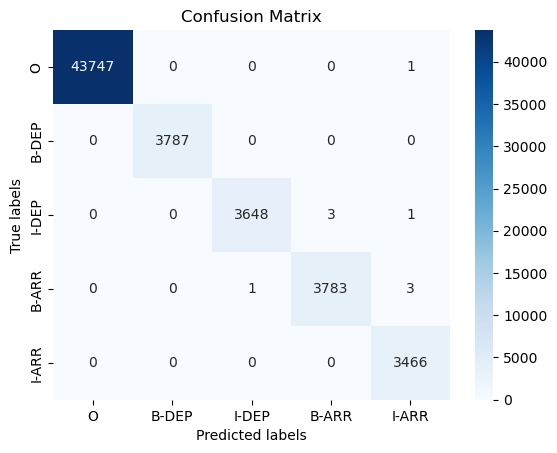

In [16]:
# Display confusion matrix
flat_y_true = [item for sublist in y_true for item in sublist]
flat_y_pred = [item for sublist in y_pred for item in sublist]

cm = confusion_matrix(flat_y_true, flat_y_pred, labels=label_list)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

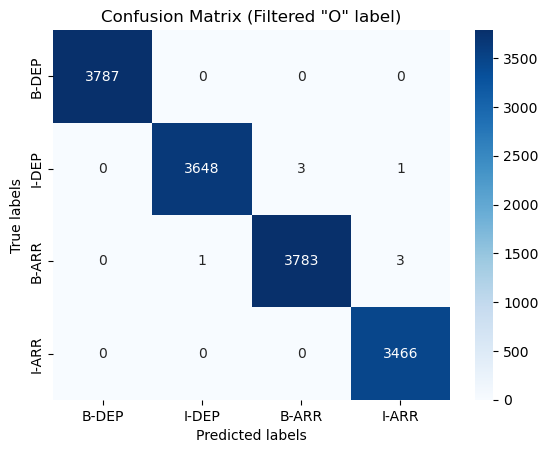

In [17]:
# Display confusion matrix without label "O"
def filter_label(label_to_exclude, true_labels, predicted_labels):
    filtered_true = [true for true, pred in zip(true_labels, predicted_labels) if pred != label_to_exclude]
    filtered_pred = [pred for pred in predicted_labels if pred != label_to_exclude]
    return filtered_true, filtered_pred

filtered_y_true, filtered_y_pred = filter_label("O", y_true, y_pred)

flat_filtered_y_true = [item for sublist in filtered_y_true for item in sublist]
flat_filtered_y_pred = [item for sublist in filtered_y_pred for item in sublist]

cm = confusion_matrix(flat_filtered_y_true, flat_filtered_y_pred, labels=label_list[1:])

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_list[1:], yticklabels=label_list[1:])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Filtered "O" label)')
plt.show()